In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
from pyperclip import copy

libraries = ['pandas', 'polars', 'noir']

In [14]:
with open('hyperfine_results/groupby_mean.json', 'r') as f:
    json_file = json.load(f)

data = []
for result in json_file['results']:
    n_row = result['parameters']['n_row']
    lib = result['parameters']['lib']
    for time, code in zip(result['times'], result['exit_codes']):
        if code == 0: 
            data.append([n_row, lib, time])
        else:
            print(f'Error in {n_row} {lib}')


gbm_df = pd.DataFrame(data, columns=['n_row', 'lib', 'time'])

In [15]:
with open('hyperfine_results/join.json', 'r') as f:
    json_file = json.load(f)

data = []
for result in json_file['results']:
    n_row = result['parameters']['n_row']
    lib = result['parameters']['lib']
    for time, code in zip(result['times'], result['exit_codes']):
        if code == 0: 
            data.append([n_row, lib, time])
        else:
            print(f'Error in {n_row} {lib}')

j_df = pd.DataFrame(data, columns=['n_row', 'lib', 'time'])

Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 pandas
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars
Error in 10000000 polars


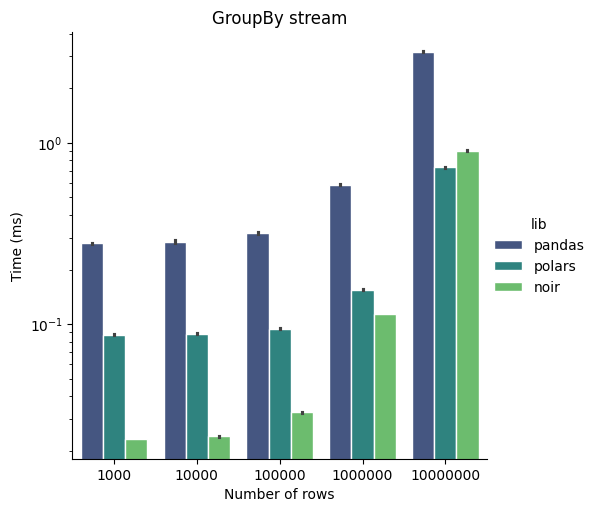

In [23]:
sns.catplot(data=gbm_df, x='n_row', y='time', hue='lib', kind='bar', palette='viridis', edgecolor='white')
plt.yscale('log')
plt.title('GroupBy stream')
plt.ylabel('Time (ms)')
plt.xlabel('Number of rows')
plt.savefig('figures/cmp_groupby.png', bbox_inches='tight')

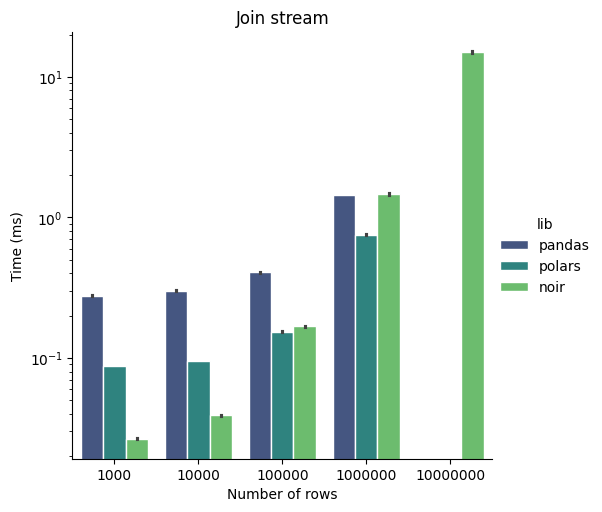

In [22]:
sns.catplot(data=j_df, x='n_row', y='time', hue='lib', kind='bar', palette='viridis', edgecolor='white')
plt.yscale('log')
plt.title('Join stream')
plt.ylabel('Time (ms)')
plt.xlabel('Number of rows')
plt.savefig('figures/cmp_join.png', bbox_inches='tight')

In [32]:
def copy_latex(data: pd.DataFrame, factor: float = .001):
    data = data.groupby(['lib', 'n_row'])['time'].agg(['mean', 'std'])
    new_index = []
    for index in data.index:
        new_index.append((f'\\textbf{{{index[0].capitalize()}}}', index[1]))
    data.set_index(pd.MultiIndex.from_tuples(new_index, names=['Library', 'Rows']), inplace=True)
    data['time'] = data.apply(lambda row: f'{(row["mean"] / factor):.2f} $\\pm$  {(row["std"] / factor):.2f}', axis=1)
    data = data.pivot_table(index='Library', columns='Rows', values='time', aggfunc='first')
    copy(data.to_latex(escape=False))

In [33]:
copy_latex(gbm_df)

In [34]:
copy_latex(j_df)

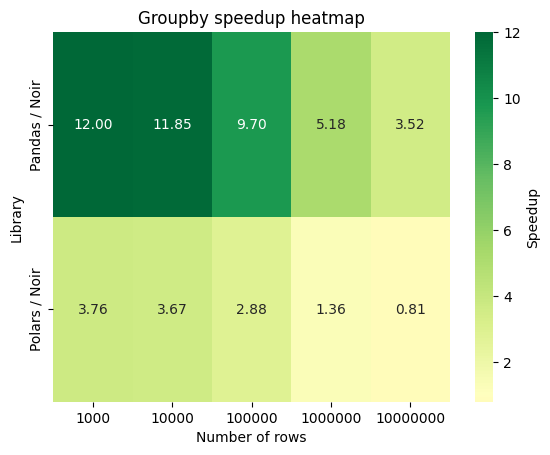

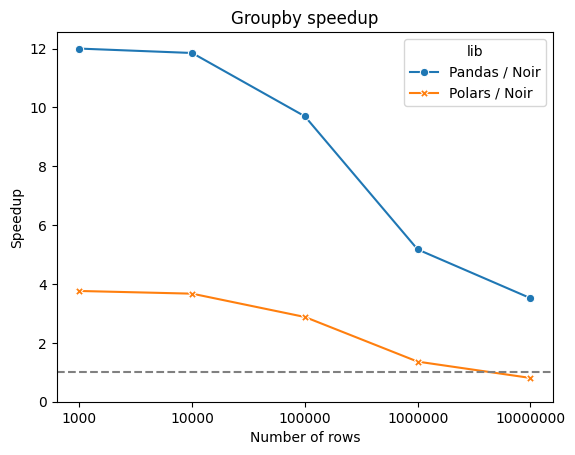

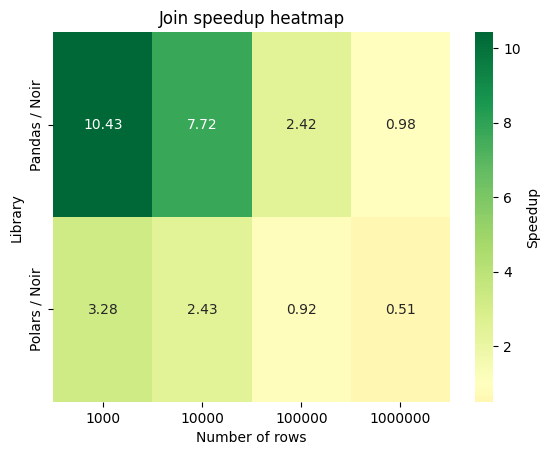

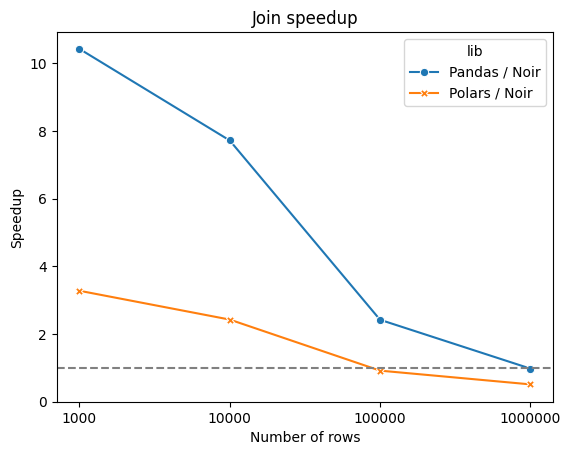

In [51]:
def speedup(data: pd.DataFrame, stream: str):
    data = data.groupby(['lib', 'n_row'])['time'].mean().reset_index()
    noir_data = data[data['lib'] == 'noir']
    pandas_data = data[data['lib'] == 'pandas']
    polars_data = data[data['lib'] == 'polars']

    pandas_speedup = noir_data.merge(pandas_data, on='n_row', suffixes=('_noir', '_pandas'))
    pandas_speedup['speedup'] = pandas_speedup['time_pandas'] / pandas_speedup['time_noir']
    pandas_speedup['lib'] = 'Pandas / Noir'
    pandas_speedup = pandas_speedup[['n_row', 'speedup', 'lib']]

    polars_speedup = noir_data.merge(polars_data, on='n_row', suffixes=('_noir', '_polars'))
    polars_speedup['speedup'] = polars_speedup['time_polars'] / polars_speedup['time_noir']
    polars_speedup['lib'] = 'Polars / Noir'
    polars_speedup = polars_speedup[['n_row', 'speedup', 'lib']]

    speedup = pd.concat([pandas_speedup, polars_speedup])
    speedup_pivot = speedup.pivot_table(index='lib', columns='n_row', values='speedup', aggfunc='first')
    sns.heatmap(speedup_pivot, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Speedup'}, fmt='.2f', center=1.0)
    plt.title(f'{stream.capitalize()} speedup heatmap')
    plt.xlabel('Number of rows')
    plt.ylabel('Library')
    plt.savefig(f'figures/cpm-{stream}-speedup.png', bbox_inches='tight')
    plt.show()
    return speedup

def generate_speedup_line(speedup: pd.DataFrame, prefix: str, logx: bool = False, logy: bool = False):
    sns.lineplot(data=speedup, x='n_row', y='speedup', hue='lib', markers=True, style='lib', dashes=False)
    # dashed line at 1
    plt.axhline(1, color='gray', linestyle='--')
    xticks = speedup['n_row'].unique()
    if logx: plt.xscale('log')
    if logy: plt.yscale('log')
    plt.title(f'{prefix.capitalize()} speedup')
    plt.ylabel('Speedup')
    plt.xlabel('Number of rows')
    plt.xticks(ticks=xticks, labels=[str(tick) for tick in xticks])
    plt.ylim(bottom=0)
    plt.savefig(f'figures/cmp-{prefix}-speedup-line.png')
    plt.show()

data = speedup(gbm_df, 'groupby')
generate_speedup_line(data, 'groupby')

data = speedup(j_df, 'join')
generate_speedup_line(data, 'join')